In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar o DataFrame
df = pd.read_excel('C:/Users/Patyc/OneDrive/Desktop/Dissertation/Data/Skin_clean and treated/Skin_clean.xlsx')

# Converter a data para datetime e ordenar de forma crescente
df['Screening_date'] = pd.to_datetime(df['Screening_date'])
df = df.sort_values(by='Screening_date')

df

,Screening_date,Gender,Age,Personal_cancer_history,Family_cancer_history,Sun_exposure,Body_signs,Premalignant,Malignant,Phototype_2,Phototype_3,Phototype_4,Phototype_5,Phototype_6
5901,2022-03-03,1.0,NaN,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0
5895,2022-03-03,0.0,NaN,0.0,0.0,1.0,0.0,1,0,0,1,0,0,0
5896,2022-03-03,1.0,NaN,0.0,0.0,1.0,1.0,0,0,0,1,0,0,0
5897,2022-03-03,0.0,NaN,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0
5898,2022-03-03,1.0,NaN,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4481,2024-04-27,0.0,23.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0
4480,2024-04-27,1.0,81.0,1.0,0.0,1.0,1.0,0,1,1,0,0,0,0
4479,2024-04-27,1.0,59.0,1.0,1.0,0.0,1.0,0,1,1,0,0,0,0
8049,2024-04-27,1.0,63.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0


In [2]:
# Lista das colunas que deseja eliminar
columns_to_drop = [
    'Gender', 'Age', 'Personal_cancer_history', 'Family_cancer_history',
    'Sun_exposure', 'Body_signs', 'Premalignant', 'Malignant',
    'Phototype_2', 'Phototype_3', 'Phototype_4', 'Phototype_5', 'Phototype_6'
]

# Eliminar as colunas do DataFrame
df = df.drop(columns=columns_to_drop)

df

df.columns

Index(['Screening_date'], dtype='object')

In [3]:
# Criar as variáveis exógenas (VVs) diretamente a partir da data dos rastreios
df['Ano'] = df['Screening_date'].dt.year
df['Mês'] = df['Screening_date'].dt.month
df['Dia_da_Semana'] = df['Screening_date'].dt.day_name()
df['Semana_do_Ano'] = df['Screening_date'].dt.isocalendar().week

df


,Screening_date,Ano,Mês,Dia_da_Semana,Semana_do_Ano
5901,2022-03-03,2022,3,Thursday,9
5895,2022-03-03,2022,3,Thursday,9
5896,2022-03-03,2022,3,Thursday,9
5897,2022-03-03,2022,3,Thursday,9
5898,2022-03-03,2022,3,Thursday,9
...,...,...,...,...,...
4481,2024-04-27,2024,4,Saturday,17
4480,2024-04-27,2024,4,Saturday,17
4479,2024-04-27,2024,4,Saturday,17
8049,2024-04-27,2024,4,Saturday,17


In [4]:
from scipy.stats import mode

# Criar a coluna 'Semana' para agrupar por semana
df['Semana'] = df['Screening_date'].dt.to_period('W').apply(lambda r: r.start_time)

# Agora agregue as VVs corretamente
df_week = df.groupby('Semana').agg({
    'Ano': 'first',                           # Ano da primeira ocorrência na semana
    'Mês': 'first',                           # Mês da primeira ocorrência na semana
    'Dia_da_Semana': lambda x: x.mode()[0], # Dia da semana mais frequente
    'Semana_do_Ano': 'first'                 # Semana do ano da primeira ocorrência na semana                  
}).reset_index()

# Adicionar a contagem de rastreios por semana
df_week['week_screenings'] = df.groupby('Semana')['Screening_date'].size().values

# Renomear a coluna 'Screening_date' para 'week_screenings'
df_week.rename(columns={'Screening_date': 'week_screenings'}, inplace=True)

# Remover as linhas onde week_screenings é igual a 0 (opcional)
df_week = df_week[df_week['week_screenings'] != 0]

df_week

,Semana,Ano,Mês,Dia_da_Semana,Semana_do_Ano,week_screenings
0,2022-02-28,2022,3,Thursday,9,92
1,2022-03-14,2022,3,Saturday,11,62
2,2022-03-21,2022,3,Saturday,12,90
3,2022-04-04,2022,4,Saturday,14,139
4,2022-04-18,2022,4,Saturday,16,173
...,...,...,...,...,...,...
70,2024-03-18,2024,3,Saturday,12,168
71,2024-03-25,2024,3,Saturday,13,198
72,2024-04-01,2024,4,Saturday,14,242
73,2024-04-15,2024,4,Saturday,16,186


In [5]:
# Criar variáveis dummy para 'Dia_da_Semana'
df_week = pd.get_dummies(df_week, columns=['Dia_da_Semana'], drop_first=True)

df_week

,Semana,Ano,Mês,Semana_do_Ano,week_screenings,Dia_da_Semana_Monday,Dia_da_Semana_Saturday,Dia_da_Semana_Sunday,Dia_da_Semana_Thursday,Dia_da_Semana_Wednesday
0,2022-02-28,2022,3,9,92,False,False,False,True,False
1,2022-03-14,2022,3,11,62,False,True,False,False,False
2,2022-03-21,2022,3,12,90,False,True,False,False,False
3,2022-04-04,2022,4,14,139,False,True,False,False,False
4,2022-04-18,2022,4,16,173,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,3,12,168,False,True,False,False,False
71,2024-03-25,2024,3,13,198,False,True,False,False,False
72,2024-04-01,2024,4,14,242,False,True,False,False,False
73,2024-04-15,2024,4,16,186,False,True,False,False,False


In [6]:
# Select the columns that start with 'Dia_da_Semana_'
dia_da_semana_columns = [col for col in df_week.columns if col.startswith('Dia_da_Semana_')]

# Convert True/False to 0/1
df_week[dia_da_semana_columns] = df_week[dia_da_semana_columns].astype(int)

In [7]:
df_week

,Semana,Ano,Mês,Semana_do_Ano,week_screenings,Dia_da_Semana_Monday,Dia_da_Semana_Saturday,Dia_da_Semana_Sunday,Dia_da_Semana_Thursday,Dia_da_Semana_Wednesday
0,2022-02-28,2022,3,9,92,0,0,0,1,0
1,2022-03-14,2022,3,11,62,0,1,0,0,0
2,2022-03-21,2022,3,12,90,0,1,0,0,0
3,2022-04-04,2022,4,14,139,0,1,0,0,0
4,2022-04-18,2022,4,16,173,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,3,12,168,0,1,0,0,0
71,2024-03-25,2024,3,13,198,0,1,0,0,0
72,2024-04-01,2024,4,14,242,0,1,0,0,0
73,2024-04-15,2024,4,16,186,0,1,0,0,0


In [8]:
# Calcular variáveis adicionais após a agregação
df_week['Total_Cumulativo'] = df_week['week_screenings'].cumsum()
df_week['Diferença_Semanal'] = df_week['week_screenings'].diff().fillna(0)
df_week['Tendência_4_Semanas'] = df_week['week_screenings'].rolling(window=4).mean()

# Exibir o DataFrame final
df_week




,Semana,Ano,Mês,Semana_do_Ano,week_screenings,Dia_da_Semana_Monday,Dia_da_Semana_Saturday,Dia_da_Semana_Sunday,Dia_da_Semana_Thursday,Dia_da_Semana_Wednesday,Total_Cumulativo,Diferença_Semanal,Tendência_4_Semanas
0,2022-02-28,2022,3,9,92,0,0,0,1,0,92,0.0,NaN
1,2022-03-14,2022,3,11,62,0,1,0,0,0,154,-30.0,NaN
2,2022-03-21,2022,3,12,90,0,1,0,0,0,244,28.0,NaN
3,2022-04-04,2022,4,14,139,0,1,0,0,0,383,49.0,95.75
4,2022-04-18,2022,4,16,173,0,1,0,0,0,556,34.0,116.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,3,12,168,0,1,0,0,0,7584,-240.0,243.25
71,2024-03-25,2024,3,13,198,0,1,0,0,0,7782,30.0,243.00
72,2024-04-01,2024,4,14,242,0,1,0,0,0,8024,44.0,254.00
73,2024-04-15,2024,4,16,186,0,1,0,0,0,8210,-56.0,198.50


In [9]:
df_week.columns

Index(['Semana', 'Ano', 'Mês', 'Semana_do_Ano', 'week_screenings',
       'Dia_da_Semana_Monday', 'Dia_da_Semana_Saturday',
       'Dia_da_Semana_Sunday', 'Dia_da_Semana_Thursday',
       'Dia_da_Semana_Wednesday', 'Total_Cumulativo', 'Diferença_Semanal',
       'Tendência_4_Semanas'],
      dtype='object')

DATE REALTED VARIABLES CORRELATION

                              Ano       Mês  Semana_do_Ano  week_screenings  \
Ano                      1.000000 -0.524732      -0.515522         0.304480   
Mês                     -0.524732  1.000000       0.996385        -0.183986   
Semana_do_Ano           -0.515522  0.996385       1.000000        -0.187669   
week_screenings          0.304480 -0.183986      -0.187669         1.000000   
Dia_da_Semana_Monday    -0.075227 -0.011720      -0.015810         0.113278   
Dia_da_Semana_Saturday   0.109765 -0.059599      -0.067624        -0.059389   
Dia_da_Semana_Sunday    -0.075227  0.012697       0.018231         0.124880   
Dia_da_Semana_Thursday  -0.084282  0.028385       0.031269         0.000250   
Dia_da_Semana_Wednesday  0.028034  0.060361       0.072572        -0.031127   
Total_Cumulativo         0.904107 -0.143309      -0.129404         0.329244   
Diferença_Semanal        0.031355 -0.031133      -0.049310         0.587679   
Tendência_4_Semanas      0.350742 -0.178037      -0.

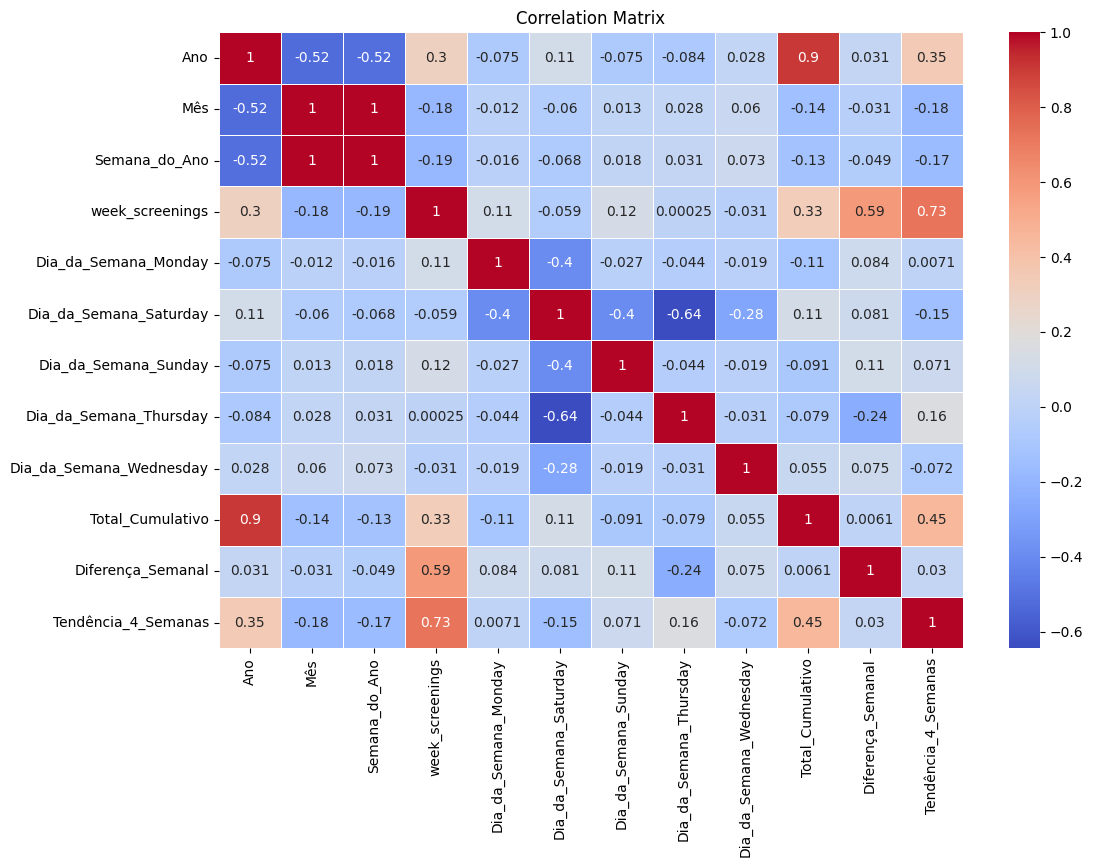

In [10]:
import seaborn as sns

# Select the relevant columns for correlation analysis
columns_to_analyze = [
    'Ano', 'Mês', 'Semana_do_Ano', 'week_screenings',
    'Dia_da_Semana_Monday', 'Dia_da_Semana_Saturday',
    'Dia_da_Semana_Sunday', 'Dia_da_Semana_Thursday',
    'Dia_da_Semana_Wednesday', 'Total_Cumulativo', 'Diferença_Semanal',
    'Tendência_4_Semanas'
]

# Compute the correlation matrix
correlation_matrix = df_week[columns_to_analyze].corr()

# Display the correlation matrix
print(correlation_matrix)

# Optionally, visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [11]:
# Remove the 'Total_Cumulativo' column from df_week
df_week = df_week.drop(columns=['Total_Cumulativo'])

df_week

,Semana,Ano,Mês,Semana_do_Ano,week_screenings,Dia_da_Semana_Monday,Dia_da_Semana_Saturday,Dia_da_Semana_Sunday,Dia_da_Semana_Thursday,Dia_da_Semana_Wednesday,Diferença_Semanal,Tendência_4_Semanas
0,2022-02-28,2022,3,9,92,0,0,0,1,0,0.0,NaN
1,2022-03-14,2022,3,11,62,0,1,0,0,0,-30.0,NaN
2,2022-03-21,2022,3,12,90,0,1,0,0,0,28.0,NaN
3,2022-04-04,2022,4,14,139,0,1,0,0,0,49.0,95.75
4,2022-04-18,2022,4,16,173,0,1,0,0,0,34.0,116.00
...,...,...,...,...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,3,12,168,0,1,0,0,0,-240.0,243.25
71,2024-03-25,2024,3,13,198,0,1,0,0,0,30.0,243.00
72,2024-04-01,2024,4,14,242,0,1,0,0,0,44.0,254.00
73,2024-04-15,2024,4,16,186,0,1,0,0,0,-56.0,198.50


In [12]:
# Remove the 'Total_Cumulativo' column from df_week
df_week = df_week.drop(columns=['Mês'])

df_week

,Semana,Ano,Semana_do_Ano,week_screenings,Dia_da_Semana_Monday,Dia_da_Semana_Saturday,Dia_da_Semana_Sunday,Dia_da_Semana_Thursday,Dia_da_Semana_Wednesday,Diferença_Semanal,Tendência_4_Semanas
0,2022-02-28,2022,9,92,0,0,0,1,0,0.0,NaN
1,2022-03-14,2022,11,62,0,1,0,0,0,-30.0,NaN
2,2022-03-21,2022,12,90,0,1,0,0,0,28.0,NaN
3,2022-04-04,2022,14,139,0,1,0,0,0,49.0,95.75
4,2022-04-18,2022,16,173,0,1,0,0,0,34.0,116.00
...,...,...,...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,12,168,0,1,0,0,0,-240.0,243.25
71,2024-03-25,2024,13,198,0,1,0,0,0,30.0,243.00
72,2024-04-01,2024,14,242,0,1,0,0,0,44.0,254.00
73,2024-04-15,2024,16,186,0,1,0,0,0,-56.0,198.50


# ANÁLISE WEEK_SCREENINGS

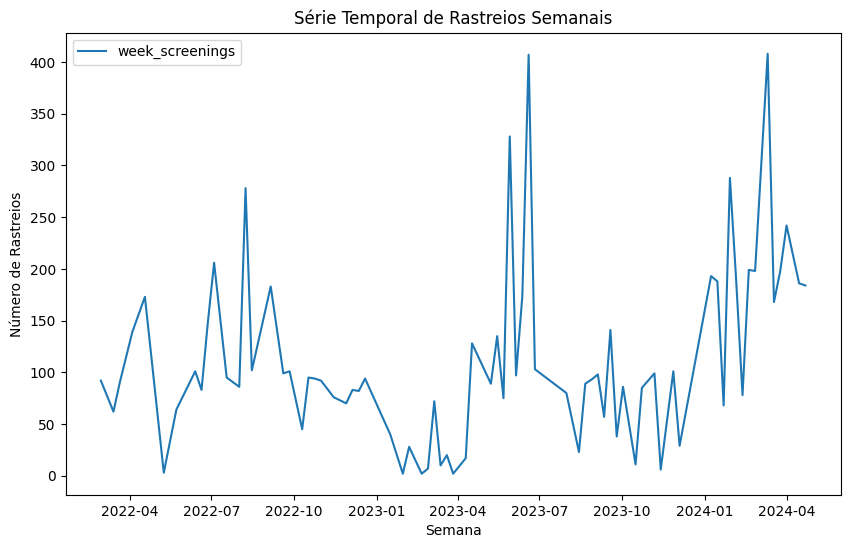

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df_week['Semana'], df_week['week_screenings'], label='week_screenings')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Série Temporal de Rastreios Semanais')
plt.legend()
plt.show()

Estatísticas Descritivas

In [15]:
print(df_week['week_screenings'].describe())

count     75.000000
mean     111.920000
std       86.173264
min        2.000000
25%       66.000000
50%       93.000000
75%      158.000000
max      408.000000
Name: week_screenings, dtype: float64


Dispersão e Variedade: O desvio padrão relativamente alto (86.92) em comparação com a média (110.45) indica que há uma ampla dispersão nos dados.

Assimetria e Distribuição: A diferença entre a mediana (92) e a média (110.45) sugere que a distribuição pode ser assimétrica, possivelmente com uma cauda à direita mais longa (distribuição positiva). Isso é reforçado pelo fato de que o 75º percentil (159.75) está bastante distante da mediana (92) e do 25º percentil (66.25).

Faixa de Dados: A diferença entre o mínimo (2) e o máximo (408) também sugere uma grande variação nos valores.

Estacionariedade

In [14]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_week['week_screenings'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.3854791228960286
p-value: 0.14587683122582956


Com um valor-p de 0.1458, que é maior que 0.05, você não rejeita a hipótese nula. Isso sugere que há uma evidência insuficiente para afirmar que a série temporal é estacionária. Em outras palavras, a série pode ser não estacionária.

Tornar a série estacionária

In [15]:
# Definir a série temporal
series = df_week['week_screenings']

# Aplicar a diferenciação de ordem 1 e adicionar a nova coluna
df_week['week_screenings_diff'] = series.diff()

# Remover a coluna original 'week_screenings'
df_week.drop(columns=['week_screenings'], inplace=True)

# Remover linhas com NaN, se necessário (por exemplo, a primeira linha após a diferenciação)
df_week.dropna(subset=['week_screenings_diff'], inplace=True)

df_week

,Semana,Ano,Semana_do_Ano,Dia_da_Semana_Monday,Dia_da_Semana_Saturday,Dia_da_Semana_Sunday,Dia_da_Semana_Thursday,Dia_da_Semana_Wednesday,Diferença_Semanal,Tendência_4_Semanas,week_screenings_diff
1,2022-03-14,2022,11,0,1,0,0,0,-30.0,NaN,-30.0
2,2022-03-21,2022,12,0,1,0,0,0,28.0,NaN,28.0
3,2022-04-04,2022,14,0,1,0,0,0,49.0,95.75,49.0
4,2022-04-18,2022,16,0,1,0,0,0,34.0,116.00,34.0
5,2022-05-09,2022,19,0,1,0,0,0,-170.0,101.25,-170.0
...,...,...,...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,12,0,1,0,0,0,-240.0,243.25,-240.0
71,2024-03-25,2024,13,0,1,0,0,0,30.0,243.00,30.0
72,2024-04-01,2024,14,0,1,0,0,0,44.0,254.00,44.0
73,2024-04-15,2024,16,0,1,0,0,0,-56.0,198.50,-56.0


In [16]:
# Renomear a coluna 'week_screenings_diff' para 'week_screenings'
df_week.rename(columns={'week_screenings_diff': 'week_screenings'}, inplace=True)

In [17]:
print(df_week.columns)

Index(['Semana', 'Ano', 'Semana_do_Ano', 'Dia_da_Semana_Monday',
       'Dia_da_Semana_Saturday', 'Dia_da_Semana_Sunday',
       'Dia_da_Semana_Thursday', 'Dia_da_Semana_Wednesday',
       'Diferença_Semanal', 'Tendência_4_Semanas', 'week_screenings'],
      dtype='object')


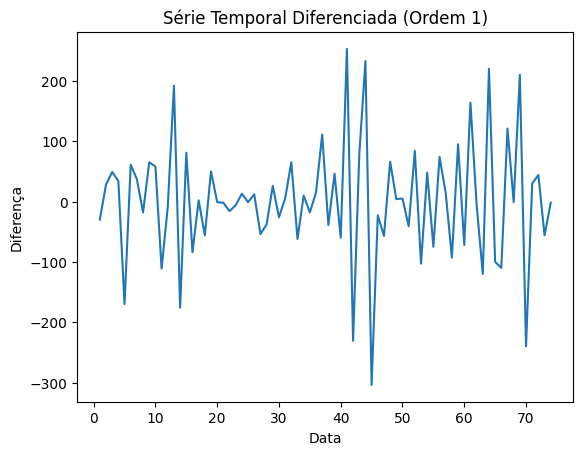

In [18]:
import matplotlib.pyplot as plt

# Visualizar a série temporal diferenciada
df_week['week_screenings'].plot(title='Série Temporal Diferenciada (Ordem 1)')
plt.xlabel('Data')
plt.ylabel('Diferença')
plt.show()

In [512]:
df_week

,Semana,Ano,Mês,Semana_do_Ano,Dia_da_Semana_Monday,Dia_da_Semana_Saturday,Dia_da_Semana_Sunday,Dia_da_Semana_Thursday,Dia_da_Semana_Wednesday,Diferença_Semanal,Tendência_4_Semanas,week_screenings
1,2022-03-14,2022,3,11,0,1,0,0,0,-30.0,NaN,-30.0
2,2022-03-21,2022,3,12,0,1,0,0,0,28.0,NaN,28.0
3,2022-04-04,2022,4,14,0,1,0,0,0,49.0,95.75,49.0
4,2022-04-18,2022,4,16,0,1,0,0,0,34.0,116.00,34.0
5,2022-05-09,2022,5,19,0,1,0,0,0,-170.0,101.25,-170.0
...,...,...,...,...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,3,12,0,1,0,0,0,-240.0,243.25,-240.0
71,2024-03-25,2024,3,13,0,1,0,0,0,30.0,243.00,30.0
72,2024-04-01,2024,4,14,0,1,0,0,0,44.0,254.00,44.0
73,2024-04-15,2024,4,16,0,1,0,0,0,-56.0,198.50,-56.0


Decomposição da série temporal

In [513]:
df_week.columns

Index(['Semana', 'Ano', 'Mês', 'Semana_do_Ano', 'Dia_da_Semana_Monday',
       'Dia_da_Semana_Saturday', 'Dia_da_Semana_Sunday',
       'Dia_da_Semana_Thursday', 'Dia_da_Semana_Wednesday',
       'Diferença_Semanal', 'Tendência_4_Semanas', 'week_screenings'],
      dtype='object')

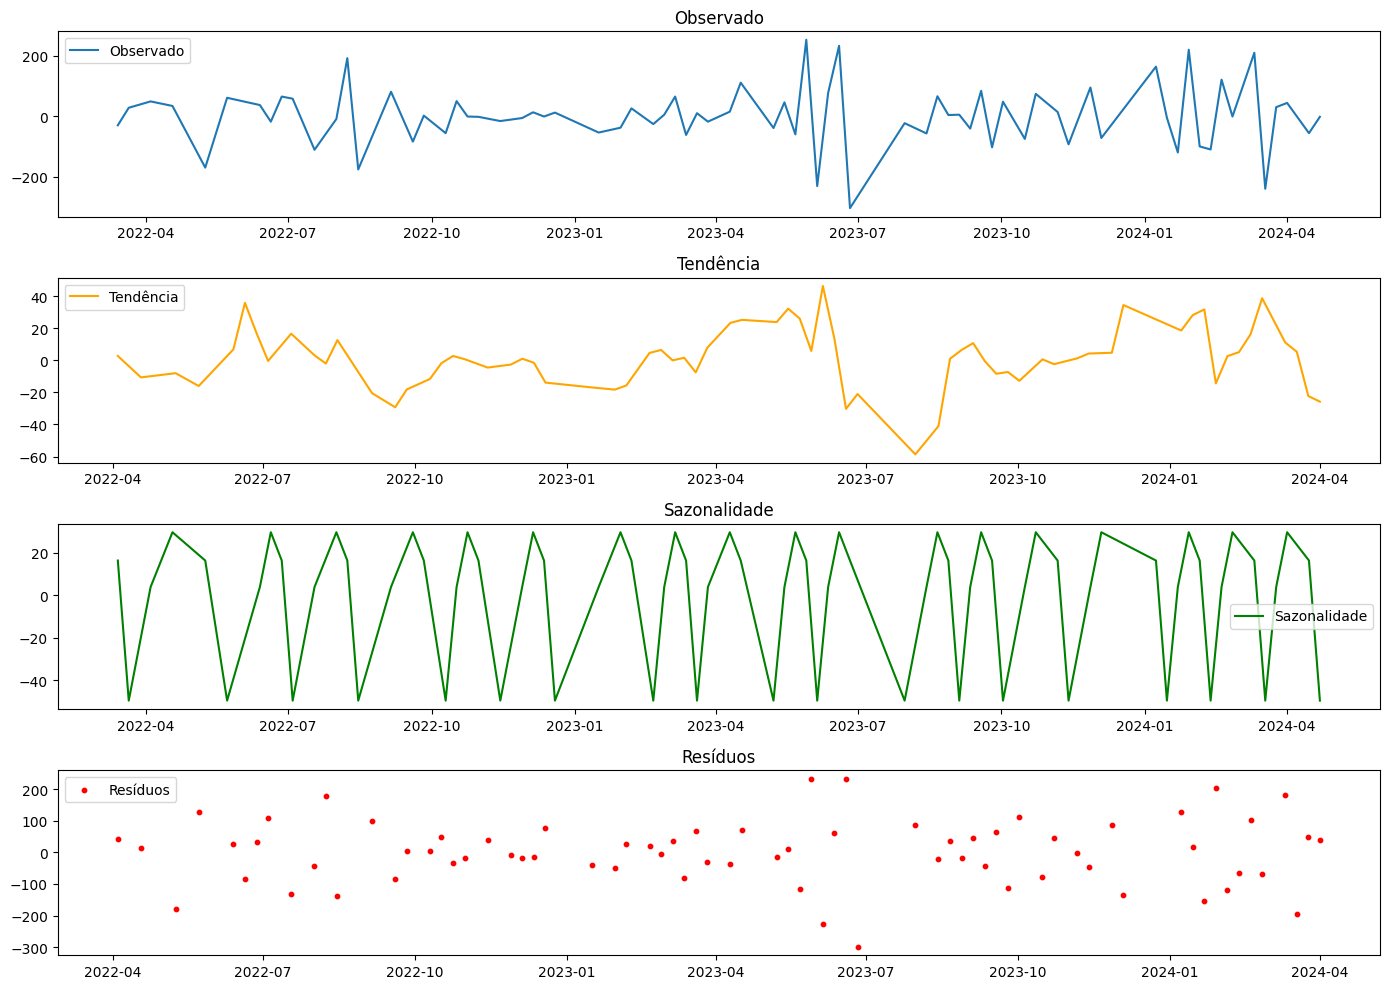

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Definir a série temporal com a frequência correta (semana)
df_week.set_index('Semana', inplace=True)
series = df_week['week_screenings']

# Aplicar a decomposição
decomposition = seasonal_decompose(series, model='additive', period=4)  # period=52 para dados semanais

# Plotar a decomposição
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observado')
plt.title('Observado')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Tendência', color='orange')
plt.title('Tendência')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Sazonalidade', color='green')
plt.title('Sazonalidade')
plt.legend()

# Gráfico dos Resíduos como pontos
plt.subplot(4, 1, 4)
plt.scatter(decomposition.resid.index, decomposition.resid, label='Resíduos', color='red', s=10)  # s é o tamanho dos pontos
plt.title('Resíduos')
plt.legend()

plt.tight_layout()
plt.show()


Observed Data (First Plot): This is the original time series data. The values fluctuate over time, showing some level of variability. There are notable dips and spikes, which may indicate significant events or shifts in the underlying data.

Trend Component (Second Plot): The trend shows the long-term movement in the data, filtered from the noise and seasonal patterns. The trend line here fluctuates, particularly with a noticeable peak around mid-2023 and a gradual decline afterward. This suggests some underlying long-term factors influencing the data, possibly related to external factors or gradual changes in the system being analyzed.

Seasonality Component (Third Plot): The seasonality plot shows repeating patterns at regular intervals, indicating that the data has a cyclical component that repeats over time. The consistent up-and-down pattern suggests a strong seasonal effect, which could be tied to predictable events or cycles, such as monthly or quarterly changes.

Residuals (Fourth Plot): Residuals represent the random noise or the part of the data that cannot be explained by the trend or seasonality. Ideally, the residuals should not show any pattern, and they should be randomly scattered around zero. In this case, the residuals are relatively well-distributed, though there might be some minor clustering that could suggest areas where the model might not fully capture the data's behavior.

Autocorrelação e Parcial Autocorrelação

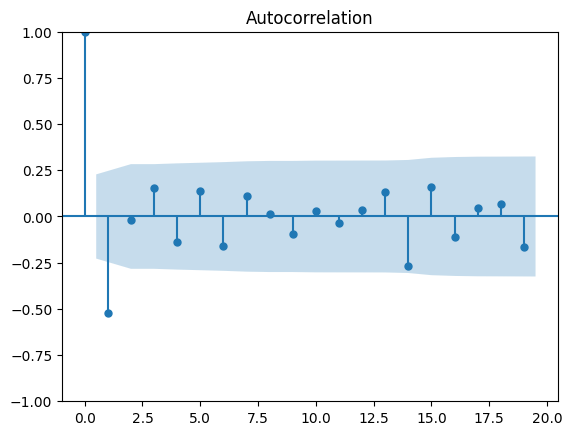

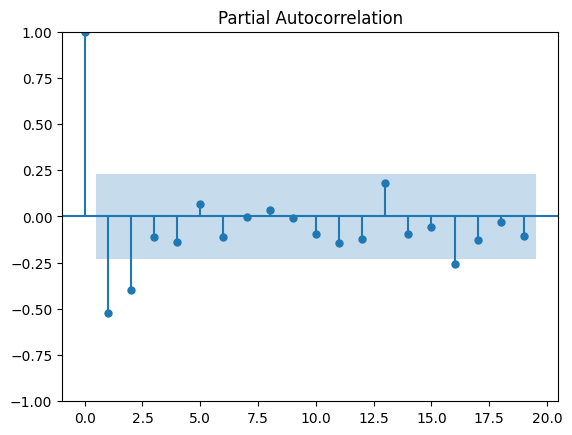

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_week['week_screenings'])
plot_pacf(df_week['week_screenings'])
plt.show()

# MODELO SARIMAX

In [19]:
# Check for NaN values
print("Number of NaN values in each column before cleaning:")
print(df_week.isna().sum())

Number of NaN values in each column before cleaning:
Semana                     0
Ano                        0
Semana_do_Ano              0
Dia_da_Semana_Monday       0
Dia_da_Semana_Saturday     0
Dia_da_Semana_Sunday       0
Dia_da_Semana_Thursday     0
Dia_da_Semana_Wednesday    0
Diferença_Semanal          0
Tendência_4_Semanas        2
week_screenings            0
dtype: int64


In [20]:
# Drop rows where 'Tendência_4_Semanas' has NaN values
df_week = df_week.dropna(subset=['Tendência_4_Semanas'])

# Verify that the NaN values have been removed
print("Number of NaN values in each column after cleaning:")
print(df_week.isna().sum())

Number of NaN values in each column after cleaning:
Semana                     0
Ano                        0
Semana_do_Ano              0
Dia_da_Semana_Monday       0
Dia_da_Semana_Saturday     0
Dia_da_Semana_Sunday       0
Dia_da_Semana_Thursday     0
Dia_da_Semana_Wednesday    0
Diferença_Semanal          0
Tendência_4_Semanas        0
week_screenings            0
dtype: int64


In [21]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming 'df_week' is your DataFrame and 'week_screenings' is your target variable

# Ensure all exogenous variables are numeric
exog_vars = df_week[['Ano', 'Semana_do_Ano', 'Dia_da_Semana_Monday',
                     'Dia_da_Semana_Saturday', 'Dia_da_Semana_Sunday',
                     'Dia_da_Semana_Thursday', 'Dia_da_Semana_Wednesday',
                     'Diferença_Semanal', 'Tendência_4_Semanas']]

# Force all columns to be numeric and handle any errors
exog_vars = exog_vars.apply(pd.to_numeric, errors='coerce')

# Also ensure the dependent variable is numeric
df_week['week_screenings'] = pd.to_numeric(df_week['week_screenings'], errors='coerce')


C:\Users\Patyc\AppData\Local\Temp\ipykernel_135864\2990693516.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week['week_screenings'] = pd.to_numeric(df_week['week_screenings'], errors='coerce')


In [22]:
# Remover linhas com valores nulos
exog_vars = exog_vars.dropna().astype('int64')
df_week = df_week.dropna(subset=['week_screenings'])
df_week['week_screenings'] = df_week['week_screenings'].astype('int64')


In [23]:
df_week

,Semana,Ano,Semana_do_Ano,Dia_da_Semana_Monday,Dia_da_Semana_Saturday,Dia_da_Semana_Sunday,Dia_da_Semana_Thursday,Dia_da_Semana_Wednesday,Diferença_Semanal,Tendência_4_Semanas,week_screenings
3,2022-04-04,2022,14,0,1,0,0,0,49.0,95.75,49
4,2022-04-18,2022,16,0,1,0,0,0,34.0,116.00,34
5,2022-05-09,2022,19,0,1,0,0,0,-170.0,101.25,-170
6,2022-05-23,2022,21,0,1,0,0,0,61.0,94.75,61
7,2022-06-13,2022,24,0,1,0,0,0,37.0,85.25,37
...,...,...,...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,12,0,1,0,0,0,-240.0,243.25,-240
71,2024-03-25,2024,13,0,1,0,0,0,30.0,243.00,30
72,2024-04-01,2024,14,0,1,0,0,0,44.0,254.00,44
73,2024-04-15,2024,16,0,1,0,0,0,-56.0,198.50,-56


In [24]:
# Definir a proporção de treino
train_size = int(len(df_week) * 0.8)

# Dividir os dados em treino e teste
train_data = df_week.iloc[:train_size]
test_data = df_week.iloc[train_size:]

# Separar as variáveis dependentes e exógenas
y_train = train_data['week_screenings']
y_test = test_data['week_screenings']

exog_train = train_data[['Ano', 'Semana_do_Ano', 'Dia_da_Semana_Monday',
                         'Dia_da_Semana_Saturday', 'Dia_da_Semana_Sunday',
                         'Dia_da_Semana_Thursday', 'Dia_da_Semana_Wednesday',
                         'Diferença_Semanal', 'Tendência_4_Semanas']]

exog_test = test_data[['Ano', 'Semana_do_Ano', 'Dia_da_Semana_Monday',
                       'Dia_da_Semana_Saturday', 'Dia_da_Semana_Sunday',
                       'Dia_da_Semana_Thursday', 'Dia_da_Semana_Wednesday',
                       'Diferença_Semanal', 'Tendência_4_Semanas']]


In [25]:
print(exog_train.dtypes)
print(y_train.dtypes)


Ano                          int32
Semana_do_Ano               UInt32
Dia_da_Semana_Monday         int32
Dia_da_Semana_Saturday       int32
Dia_da_Semana_Sunday         int32
Dia_da_Semana_Thursday       int32
Dia_da_Semana_Wednesday      int32
Diferença_Semanal          float64
Tendência_4_Semanas        float64
dtype: object
int64


In [26]:
# Converter todas as colunas exógenas para numéricas
exog_train = exog_train.apply(pd.to_numeric, errors='coerce')
exog_test = exog_test.apply(pd.to_numeric, errors='coerce')

# Certifique-se de que não há NaN após a conversão
exog_train = exog_train.dropna().astype('int64')
exog_test = exog_test.dropna().astype('int64')

# Converter a variável dependente para numérica
y_train = pd.to_numeric(y_train, errors='coerce').dropna().astype('int64')
y_test = pd.to_numeric(y_test, errors='coerce').dropna().astype('int64')


In [27]:
print(exog_train.dtypes)
print(y_train.dtypes)


Ano                        int64
Semana_do_Ano              int64
Dia_da_Semana_Monday       int64
Dia_da_Semana_Saturday     int64
Dia_da_Semana_Sunday       int64
Dia_da_Semana_Thursday     int64
Dia_da_Semana_Wednesday    int64
Diferença_Semanal          int64
Tendência_4_Semanas        int64
dtype: object
int64


BEST MODEL SARIMA 
(0, 0, 1) e sazonal (P, D, Q, m): (0, 1, 0, 4)

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

# Ajustar o modelo SARIMAX com dados de treino
model = sm.tsa.SARIMAX(y_train, exog=exog_train, order=(0, 0, 1), seasonal_order=(0, 1, 0, 4))
model_fit = model.fit(disp=False)

# Previsão com dados de teste
forecast = model_fit.get_forecast(steps=len(y_test), exog=exog_test)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, forecast_values)
mse = mean_squared_error(y_test, forecast_values)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, forecast_values)
me = np.mean(y_test - forecast_values)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - forecast_values) / y_test))
rme = np.mean((y_test - forecast_values) / y_test)
rmae = np.mean(np.abs(y_test - forecast_values) / np.abs(y_test))

print("Modelo: SARIMA")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# MAE: 4.9301303780187784e-14
# MSE: 3.658925054610152e-27
# RMSE: 6.048904904699819e-14
# R2: 1.0
# ME: 8.416666666666652
# MAV: 99.66666666666667
# MPV: 5.087319576826229
# RME: 1.7526312299427609
# RMAE: 5.087319576826229



c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Modelo: SARIMA
MAE: 4.3579954459952814e-14
MSE: 2.789701409860079e-27
RMSE: 5.2817624045957226e-14
R2: 1.0
ME: 8.416666666666643
MAV: 99.66666666666667
MPV: 5.087319576826233
RME: 1.752631229942766
RMAE: 5.087319576826233


c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [30]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_result = acorr_ljungbox(model_fit.resid, lags=[10], return_df=True)
print(ljung_box_result)

       lb_stat     lb_pvalue
10  111.690326  2.432997e-19


# ANÁLISE RESÍDUOS

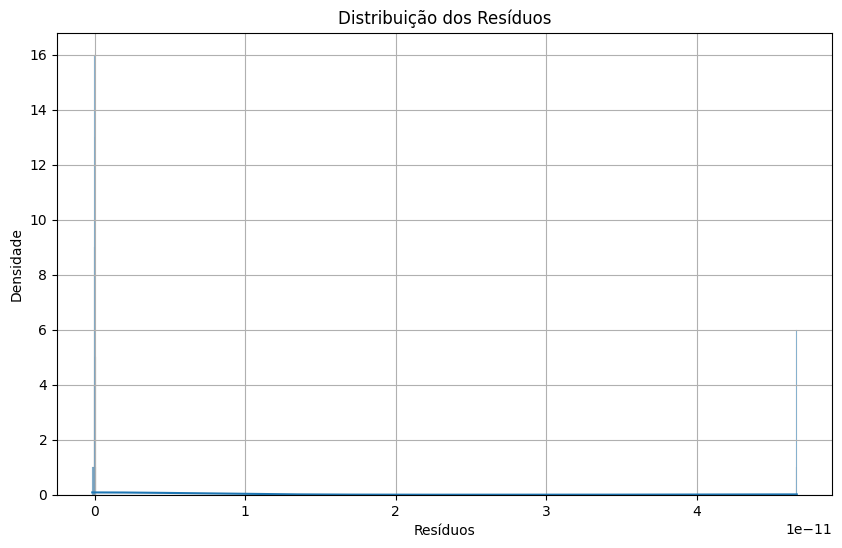

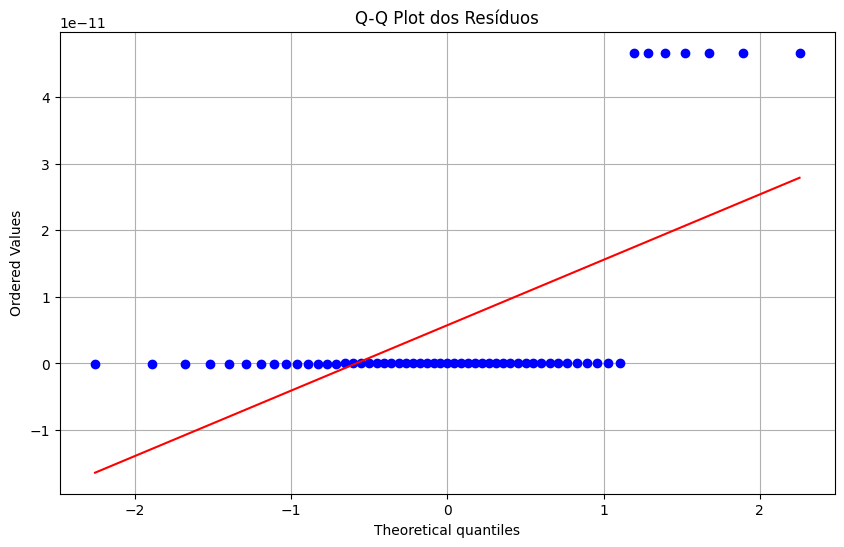

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Plotar a distribuição dos resíduos
plt.figure(figsize=(10, 6))
sns.histplot(model_fit.resid, kde=True)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Densidade')
plt.grid(True)
plt.show()

# Q-Q plot para verificar a normalidade dos resíduos
plt.figure(figsize=(10, 6))
stats.probplot(model_fit.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot dos Resíduos')
plt.grid(True)
plt.show()


Histograma: O histograma mostra uma distribuição extremamente concentrada, com a maior parte dos resíduos sendo quase zero. Isso sugere que os resíduos têm pouca variabilidade, o que é incomum e pode indicar que o modelo está superajustando ou que há algum problema na escala dos resíduos.

Q-Q Plot: O Q-Q plot mostra que a maioria dos resíduos está fortemente concentrada em torno de zero, e os pontos divergem significativamente da linha reta. Isso indica que os resíduos não seguem uma distribuição normal.

<Figure size 1000x600 with 0 Axes>

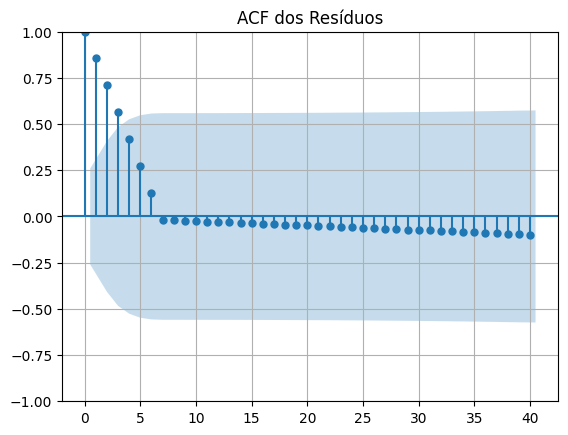

In [52]:
import statsmodels.api as sm

# Plotar o ACF dos resíduos
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(model_fit.resid, lags=40, alpha=0.05)
plt.title('ACF dos Resíduos')
plt.grid(True)
plt.show()


ACF dos Resíduos: O gráfico de autocorrelação dos resíduos mostra picos significativos nos primeiros lags, o que sugere que ainda há dependências temporais não capturadas pelo modelo. Isso é um sinal claro de que o modelo não está capturando toda a dinâmica dos dados e que os resíduos não são verdadeiramente aleatórios

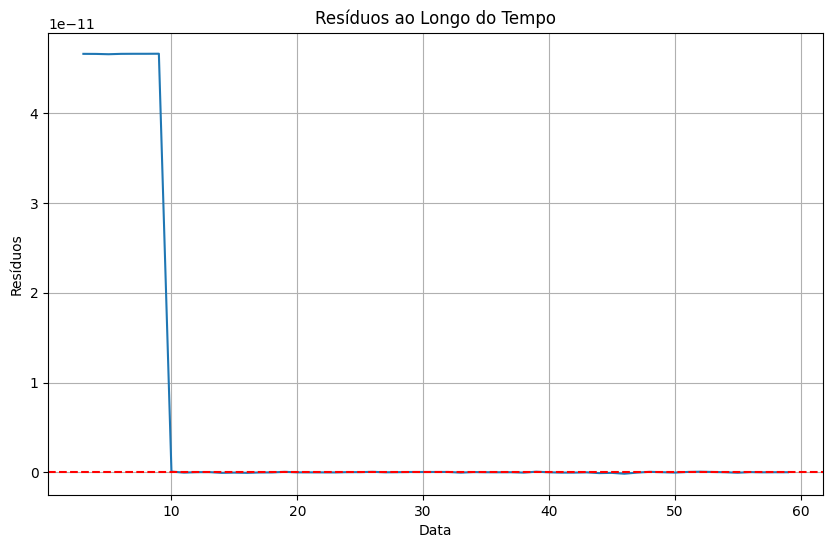

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(model_fit.resid, label='Resíduos')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Resíduos')
plt.grid(True)
plt.show()


Plot dos Resíduos ao Longo do Tempo: O gráfico mostra uma queda abrupta dos resíduos para quase zero após um certo ponto. Isso sugere que os resíduos são muito pequenos e próximos de zero, o que é incomum. Esse comportamento pode indicar que o modelo está sobreajustando os dados, resultando em resíduos artificiais.

Próximos Passos:
Revisar e Simplesificar o Modelo:

Considere simplificar o modelo, reduzindo o número de parâmetros ou verificando se a escolha das variáveis exógenas está apropriada.
Experimentar Diferentes Configurações:

Tente ajustar diferentes ordens para os componentes AR e MA (e talvez os componentes sazonais) para ver se uma configuração diferente captura melhor a estrutura dos dados.
Verificar a Escala dos Resíduos:

Verifique a escala dos resíduos para garantir que eles estão sendo calculados corretamente. Resíduos muito pequenos podem indicar problemas na escala dos dados ou nos parâmetros do modelo.
Validar com Outro Conjunto de Dados:

Se possível, teste o modelo em outro conjunto de dados (out-of-sample) para verificar se o comportamento dos resíduos se mantém.
Em resumo, os gráficos indicam que o modelo atual pode não estar capturando adequadamente a estrutura dos dados e que ajustes são necessários para melhorar a adequação do modelo.